In [200]:
import numpy as np
import matplotlib.pyplot as plt
import math
import rpyc
import time
from IPython import display
import time
from sklearn.linear_model import LinearRegression

In [2]:
try:
    ROBOT_HOSTNAME = "ev3dev.local"
    conn = rpyc.classic.connect(ROBOT_HOSTNAME)
    conn.execute("print('Hello Slave. I am your master!')")
except:
    raise Exception('No conection to rpyc server on robot possible! Is the robot conneced? Is the rpyc server started?')
    


In [3]:
motor_module = conn.modules['ev3dev2.motor']
motors = [motor_module.LargeMotor('outB'), motor_module.LargeMotor('outC')]
sensors = conn.modules['ev3dev2.sensor.lego'] 
gyro = sensors.GyroSensor('in2')
gyro.mode="GYRO-ANG"

In [32]:
def calibrate_gyro(gyro):
    gyro.mode='GYRO-CAL'
    time.sleep(1)
    gyro.mode="GYRO-ANG"
calibrate_gyro(gyro)

In [35]:
t0 = time.time()

while time.time() - t0 < 10:
    angle, rate = gyro.rate_and_angle
    
    display.clear_output(wait=True)
    display.display(angle, rate)

5

0

# Robot controls


### Movement speed:
Let $p$ be current leg position, $p'$ the requested leg position. We move the leg with speed $s$, where we select $s$ as a function of the distance to travel and the max speed.
$$
s = \frac{|p - p'|}{2} s-{max} \\
s_{min} \leq s \leq s_{max}
$$
We choose $s_{max} = 80\%$ of the maximum speed the motors are capable of. To ensure that there is some movement, se set a lower bound $s_{min} = 3\%$. 

### Robot reset
To determine when the robot comes to a standstill, we measure robot acceleration over a 3 second rolling time window. On these windows we perform linear regression, to determine the change in acceleration. If the change is near zero, the acceleration is constant and we assume the robot to be standing still.

Due to the inaccuracy of the gyroscope, using acceleration for this has been more successfull than measuring angle.

### Gyro calibration

In [257]:
class RobotControler:
    def __init__(self, connection):
        motor_module = connection.modules['ev3dev2.motor']
        self.motors = [motor_module.LargeMotor('outB'), motor_module.LargeMotor('outC')]
        sensors = conn.modules['ev3dev2.sensor.lego'] 
        self.gyro = sensors.GyroSensor('in2')
        
        self.up_position_degrees = -90 # position of legs fully in front
        self.maxspeed = 80 # maximum speed of leg movement
        self.minspeed = 3 # minimum speed of leg movement
        self.angle_normalizer = 0.01
        self.rate_normalizer = 0.01
        
        
    
    def reset(self):
        """ resets the robot, performs calibration and maintainance, return when robot is reset.
        Called at the start of each episode"""
        
        # move legs to base position
        self._move_motors_to_pos(0, 20)
        self._wait_until_no_standstill()
        _, angle = self.get_rate_and_angle()
        if angle >= 0.01:
            print('calibrating gyro')
            self._calibrate_gyro()
        return
    
    def get_rate_and_angle(self):
        """ returns the rate and angle of the robot movement"""
        angle, rate = self.gyro.rate_and_angle
        return (rate * self.rate_normalizer, angle * self.angle_normalizer)
    
    def get_current_leg_pos(self):
        """ returns the curent leg pos, on a [-1, 1] interval"""
        return self.motors[0].position /  self.up_position_degrees
    
    def move_legs(self, pos):
        """ instructs the robot where to move its legs to, on a [-1, 1] interval. Function returns immediatly."""
        pos = max(-1., min(pos, 1.))
        pos_now = self.get_current_leg_pos()
        
        s = abs(pos - pos_now) / 2 *  self.maxspeed
        s = max(self.minspeed, min(s,  self.maxspeed))
        
        self._move_motors_to_pos(pos, s)
        return
    
    def _move_motors_to_pos(self, pos, speed):
        """
        moves the motors to a position [-1, 1] at speed [0,100].
        """
        assert -1. <= pos <= 1.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        assert 0. <= speed <= 100.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        for m in self.motors:
                m.on_to_position(speed, position=pos*self.up_position_degrees, brake=True, block=False) # moves motors, non blocking.
                
    def _calibrate_gyro(self):
        self.gyro.mode='GYRO-CAL'
        time.sleep(1)
        self.gyro.mode="GYRO-ANG"
        
    def _wait_until_no_standstill(self):
        """
        waits until the gyro acceleration does not change for 3 seconds
        """
        change = 9999
        while abs(change) > 0.01: 

            rates = []
            times = []
            # sample for one second
            t0 = t = time.time()
            while t - t0 < 3:
                _, rate = self.gyro.rate_and_angle
                rates.append(rate)
                t = time.time()
                times.append(t)


            # check change in accel with linreg
            rates = abs(np.array(rates)) # take absolute rates so swinging doesnt cancel each other out
            times = np.array(times)
            lr = LinearRegression()
            lr.fit(times[:, np.newaxis], rates)  
            change = lr.coef_
            print("Waiting to stand still. Avg acceleration in previous 3s: {}".format(change[0]))

        return

In [243]:
rc = RobotControler(conn)

In [253]:
rc.get_rate_and_angle()

(0.0, 0.0)

# Validation Experiment
We reset the robot, then move the legs forward and plot the result

In [255]:
rc = RobotControler(conn)
rc.reset()

timesteps = []
angles = []
speed= []

rc.move_legs(1)

t0 = time.time()

while time.time() - t0 < 5:
    rate, angle = rc.get_rate_and_angle()
    t = time.time() - t0
    timesteps.append(t)
    angles.append(angle)
    speed.append(rate)

Waiting to stand still. Avg acceleration in previous 3s: -2.933701940987755
Waiting to stand still. Avg acceleration in previous 3s: -0.4790481599020952
Waiting to stand still. Avg acceleration in previous 3s: 0.0


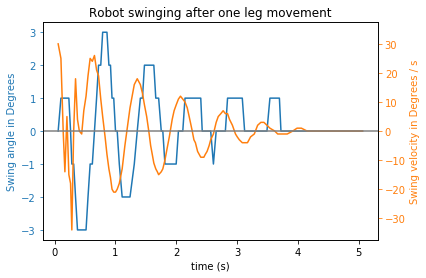

In [256]:
timesteps = np.array(timesteps)
angles = np.array(angles) / rc.angle_normalizer
maxangle = max(abs(angles))
speed= np.array(speed) / rc.rate_normalizer
maxspeed = max(abs(speed))

c0 = '#1f77b4'
c1 = '#ff7f0e'
fig, ax1 = plt.subplots()
ax1.plot(timesteps, angles, label="Swing Angle in Degrees", color=c0)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Swing angle in Degrees', color=c0)
ax1.tick_params('y', colors=c0)
ax1.set_ylim(-maxangle * 1.1 , maxangle * 1.1)
ax2 = ax1.twinx()
ax2.plot(timesteps, speed, label="Swing Velocity, in degrees / s", color=c1)
ax2.set_ylabel('Swing velocity in Degrees / s', color=c1)
ax2.tick_params('y', colors=c1)
ax2.set_ylim(-maxspeed * 1.1, maxspeed * 1.1)
plt.axhline(0, color='gray')
plt.xlabel("time $t$ in s")
plt.title('Robot swinging after one leg movement')
plt.savefig('pendulum.pdf')
plt.show()